# Step Identifier

## Why
Getting to know each step taken is key towards measuring its *quality and consequence* for a gait event during a walking session. As presented in [Fast.ai's Fastbook](https://nbviewer.org/github/fastai/fastbook/blob/master/01_intro.ipynb#Image-Recognizers-Can-Tackle-Non-Image-Tasks) literature, time series could be transformed into images that could be used to train a recognizer to identify and predict over, using capacity built for that domain.

## Brainstorm

* From a pre captured session, get an image based dataset where each sample represents a second of 3 axis waves stamped as an image. Something like the following.

![Figure 1](./per-second.png)

*  Group samples into categories (using techniques such as `from scipy.signal import find_peaks`) to get a big pictyure on how distribution works. Identifying  and differentiating steps per origin.

* [defer-for-later] Match against tri-axial device gathered data, merging the corresponding dat segment, into a single row. This will add features to each sample.

* To each origin (n, m or 1, 2), label it.

* Train a prediction model. Measure it 80/20.

* Compare models between simple (per second) and extended (half-second displaced `window`) datasets 

In [1]:
# importing libraries
%matplotlib inline
import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_raw = pd.read_csv("../datasets/wit-10hz.csv", sep='\t')
df_raw.columns = ["time", "acx", "acy", "acz","gyx", "gyy", "gyz", "roll", "pitch", "yaw"]
df_raw.drop(["gyx", "gyy", "gyz", "roll", "pitch", "yaw"], axis=1, inplace=True)

df_raw['timedf'] = pd.to_datetime(df_raw['time'])
df_raw.info()
df_raw.drop('time', axis=1, inplace=True)

df_raw['sac'] = np.sqrt(np.power(df_raw['acx'], 2) + np.power(df_raw['acy'], 2) + np.power(df_raw['acz'], 2))

df_raw.columns = ["acx", "acy", "acz", "time", "sac"]

df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64892 entries, 0 to 64891
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    64892 non-null  object        
 1   acx     64892 non-null  float64       
 2   acy     64892 non-null  float64       
 3   acz     64892 non-null  float64       
 4   timedf  64892 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 2.5+ MB


,acx,acy,acz,time,sac
0,0.094727,0.076172,0.029297,2021-05-30 11:04:36.586,0.125034
1,0.114746,0.064453,0.098633,2021-05-30 11:04:36.670,0.164467
2,0.091309,0.042969,0.109863,2021-05-30 11:04:36.760,0.149176
3,0.091309,0.054688,0.110840,2021-05-30 11:04:36.879,0.153667
4,0.007812,0.028809,0.062012,2021-05-30 11:04:36.970,0.068822


(i.e.) taking a minute from the raw dataset

In [3]:
df_raw_micro = df_raw[(df_raw['time'] > '2021-05-30 11:06') & (df_raw['time'] < '2021-05-30 11:10')]
df_raw_micro.count()
df_raw_micro

,acx,acy,acz,time,sac
823,0.108398,0.085938,0.001465,2021-05-30 11:06:00.070,0.138339
824,0.035156,0.097168,0.047363,2021-05-30 11:06:00.190,0.113670
825,0.067871,0.052734,0.068848,2021-05-30 11:06:00.280,0.110124
826,0.099121,0.043457,0.072754,2021-05-30 11:06:00.370,0.130409
827,0.018555,0.064941,0.012695,2021-05-30 11:06:00.461,0.068723
...,...,...,...,...,...
3177,0.009766,0.108398,0.050781,2021-05-30 11:09:59.536,0.120101
3178,0.100098,0.090820,0.019531,2021-05-30 11:09:59.626,0.136563
3179,0.019043,0.086914,0.042480,2021-05-30 11:09:59.716,0.098597
3180,0.119141,0.000000,0.037598,2021-05-30 11:09:59.806,0.124932


In [4]:
df_raw_micro['second'] = pd.to_datetime(df_raw_micro['time'], format='%H:%M').dt.second

# Normalizing 3-to-1
df_raw_micro['sac'] = np.sqrt(np.power(df_raw_micro['acx'], 2) + np.power(df_raw_micro['acy'], 2) + np.power(df_raw_micro['acz'], 2))

# for i in range(0,60):
#     current_second = df_raw_micro[(df_raw_micro['second'] == i)]
#     plt.figure(figsize=(10,3))
#     # sns.lineplot(y = 'acx', x = 'time', data = current_second)
#     # sns.lineplot(y = 'acy', x = 'time', data = current_second)
#     # sns.lineplot(y = 'acz', x = 'time', data = current_second)
#     sns.lineplot(y = 'sac', x = 'time', data = current_second)
#     # plt.legend(['x-axis', 'y-axis', 'z-axis'])
#     # plt.ylabel(i)
#     # plt.title(i, fontsize = 15)
#     plt.show()

## Experimenting 'windowing'

> No working nor conclusive work yet.

In [5]:
# y_rolling_avg = df_result['sac'].rolling(window=5).mean()
# #plt.plot(x, y)
# #plt.figure(10,5)
# #plt.plot(x, y_rolling_avg, color='red')
# sns.lineplot(y = 'sac', x = 'sac', data = y_rolling_avg)
# plt.show()

In [6]:
# TODO: optimize this block.
empt_array = np.array([0,0,0])
# print(empt_array)
for i in range(0,len(df_raw), 5):
    #empt_array = np.append(empt_array, [df_raw.iloc[i:i+4, 1].mean()], axis=0)
    to_add = np.array(
        [df_raw.iloc[i:i+4,4].mean(),
         df_raw.iloc[i:i+4,3].min(),
         df_raw.iloc[i:i+4,3].max()])
    empt_array = np.vstack((empt_array, to_add))
empt_array = np.delete(empt_array, 0, axis=0)

In [7]:
df_raw_micro = pd.DataFrame(empt_array, columns=["sac", "first_event", "last_event"])
df_raw_micro['time_delta'] = (df_raw_micro['first_event'] - df_raw_micro['first_event'].min())  / np.timedelta64(1,'D')
df_raw_micro['sac'] = df_raw_micro['sac'].astype(float, errors = 'raise')
df_raw_micro.drop([ "first_event", "last_event"], axis=1, inplace=True)
df_raw_micro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12979 entries, 0 to 12978
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sac         12979 non-null  float64
 1   time_delta  12979 non-null  float64
dtypes: float64(2)
memory usage: 202.9 KB


### 1. Clustering using Tslearn

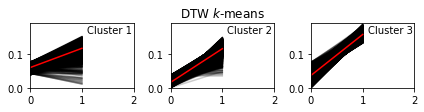

In [8]:
from tslearn.clustering import TimeSeriesKMeans


X_train = df_raw_micro.iloc[:, ::-1].to_numpy()

km = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=50)
labels = km.fit_predict(X_train)

sz = X_train.shape[1]

plt.figure()
for yi in range(3):
    plt.subplot(3, 3, 7 + yi)
    for xx in X_train[labels == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, 0.19)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

plt.tight_layout()
plt.show()

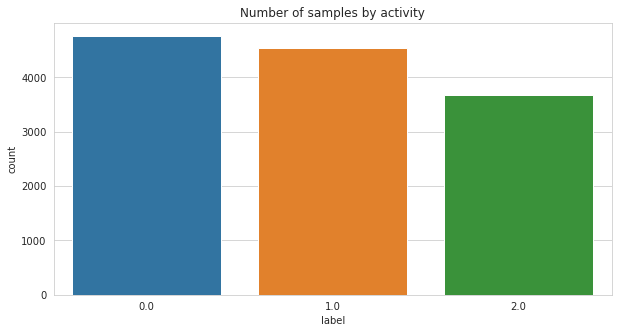

In [9]:
result = np.concatenate((X_train, labels[:,None]),axis=1)

df_result = pd.DataFrame(result)
df_result.columns = ['delta','sac','label']
sns.set_style("whitegrid")
plt.figure(figsize = (10, 5))
sns.countplot(x = 'label', data = df_result)
plt.title('Number of samples by activity')
plt.show()

### Get images per window and stack against what we have up to this point

In [10]:
# for i in range(0,60):
#     current_second = df_raw_micro[(df_raw_micro['second'] == i)]
#     plt.figure(figsize=(10,3))
#     # sns.lineplot(y = 'acx', x = 'time', data = current_second)
#     # sns.lineplot(y = 'acy', x = 'time', data = current_second)
#     # sns.lineplot(y = 'acz', x = 'time', data = current_second)
#     sns.lineplot(y = 'sac', x = 'time', data = current_second)
#     # plt.legend(['x-axis', 'y-axis', 'z-axis'])
#     # plt.ylabel(i)
#     # plt.title(i, fontsize = 15)
#     plt.show()